In [1]:
from __future__ import print_function

In [2]:
import sys
import subprocess
import json
import pandas as pd
sys.path.append('../build/')

In [3]:
%pylab inline
np.set_printoptions(precision=4, suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [4]:
import versor as vsr
import autodiff_multivector as ad
from motor_estimation import MotorEstimationSolver

In [5]:
import pprint
pp = pprint.PrettyPrinter()

In [6]:
def run_benchmarks(name, repetitions):
    proc = subprocess.Popen(['/home/game/game/build/benchmark', 
                             '--benchmark_format=json', 
                             '--benchmark_filter={}'.format(name),
                             '--benchmark_repetitions={}'.format(repetitions)],
                            stdout=subprocess.PIPE)
    stdout = proc.communicate()[0]
    return json.loads(stdout)

In [7]:
def num_statements_and_operations_from_status(status):
    line = status.splitlines()[3]
    statements = int(line.split(' ')[6])
    operations = int(line.split(' ')[11])
    return statements, operations

In [36]:
def benchmark_mean_stddev(benchmark):
    context = benchmark['context']
    mean = benchmark['benchmarks'][-2]
    mean_cpu_time = mean['cpu_time']
    mean_iterations = mean['iterations']
    mean_real_time = mean['real_time']
    stddev = benchmark['benchmarks'][-1]
    stddev_cpu_time = stddev['cpu_time']
    stddev_real_time = stddev['real_time']
    num_cpus = context['num_cpus']
    mhz_per_cpu = context['mhz_per_cpu']
    return mean_iterations, (mean_cpu_time, stddev_cpu_time), (mean_real_time, stddev_real_time), num_cpus, mhz_per_cpu

In [37]:
def benchmark_results(ad_library, ad_type, ga_library, jacobian_size, benchmark_name, num_repetitions, status=None):
    results = {}
#     results['name'] = benchmark_name
    benchmarks = run_benchmarks(benchmark_name, num_repetitions)
    if status is not None:
        num_statements, num_operations = num_statements_and_operations_from_status(status)
        results['num_statements'] = num_statements
        results['num_operations'] = num_operations
    iterations, cpu_time, real_time, num_cpus, mhz_per_cpu = benchmark_mean_stddev(benchmarks)
    results['mean_iterations'] = iterations
    results['cpu_time_mean'] = cpu_time[0]
    results['cpu_time_stddev'] = cpu_time[1]
    results['real_time_mean'] = real_time[0]
    results['real_time_stddev'] = real_time[1]
    results['ad_library'] = ad_library
    results['ad_type'] = ad_type
    results['ga_library'] = ga_library
    results['jacobian_size'] = jacobian_size
    results['num_cpus'] = num_cpus
    results['mhz_per_cpu'] = mhz_per_cpu
    return results

# Automatic Multivector Differentiation

In [41]:
results = []
num_repetitions = 2

In [42]:
results.append(benchmark_results('Adept', 'Forward', 'Matrix', (3,1), 'BM_AdeptRotorMatrixJacobianForward', 
                                 num_repetitions,
                                 ad.diff_adept_rotor_matrix_forward(0.5, vsr.Vec(1,0,0))[-1]))

In [43]:
results.append(benchmark_results('Adept', 'Reverse', 'Matrix',(3,1), 'BM_AdeptRotorMatrixJacobianReverse', 
                                 num_repetitions,
                                 ad.diff_adept_rotor_matrix_reverse(0.5, vsr.Vec(1,0,0))[-1]
                                ))

In [44]:
results.append(benchmark_results('Adept', 'Forward', 'Versor',(3,1), 'BM_AdeptRotorVersorJacobianForward', 
                                 num_repetitions,
                                 ad.diff_adept_rotor_versor_forward(0.5, vsr.Vec(1,0,0))[-1]))

In [45]:
results.append(benchmark_results('Adept', 'Reverse', 'Versor',(3,1), 'BM_AdeptRotorVersorJacobianReverse',
                                 num_repetitions,
                                 ad.diff_adept_rotor_versor_reverse(0.5, vsr.Vec(1,0,0))[-1]
                                ))

In [46]:
results.append(benchmark_results('Adept', 'Forward', 'HepGA',(3,1), 'BM_AdeptRotorHepGAJacobianForward', 
                                 num_repetitions,
                                 ad.diff_adept_rotor_hepga_forward(0.5, vsr.Vec(1,0,0))[-1]))

In [47]:
results.append(benchmark_results('Adept', 'Reverse', 'HepGA',(3,1), 'BM_AdeptRotorHepGAJacobianReverse', 
                                 num_repetitions,
                                 ad.diff_adept_rotor_hepga_reverse(0.5, vsr.Vec(1,0,0))[-1]))

In [48]:
results.append(benchmark_results('Ceres', 'Forward', 'HepGA',(3,1), 'BM_CeresRotorHepGAJacobian', num_repetitions))

In [49]:
results.append(benchmark_results('Ceres', 'Forward', 'Versor',(3,1), 'BM_CeresRotorVersorJacobian', num_repetitions))

In [50]:
results.append(benchmark_results('Ceres', 'Forward', 'Matrix',(3,1),'BM_CeresRotorMatrixJacobian', num_repetitions))

In [51]:
results.append(benchmark_results('Ceres', 'Forward', 'Versor',(5,8),'BM_CeresMotorSpinPointJacobian', num_repetitions))

In [52]:
results.append(benchmark_results('Adept', 'Forward', 'Versor',(5,8),'BM_AdeptMotorSpinPointJacobianForward', num_repetitions))

In [53]:
results.append(benchmark_results('Ceres', 'Forward', 'Versor',(3,4),'BM_CeresRotorSpinPointJacobian', num_repetitions))

In [54]:
results.append(benchmark_results('Adept', 'Forward', 'Versor',(3,4),'BM_AdeptRotorSpinPointJacobianForward', num_repetitions))

In [55]:
df_ad = pd.DataFrame(results)
df_ad.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12
ad_library,Adept,Adept,Adept,Adept,Adept,Adept,Ceres,Ceres,Ceres,Ceres,Adept,Ceres,Adept
ad_type,Forward,Reverse,Forward,Reverse,Forward,Reverse,Forward,Forward,Forward,Forward,Forward,Forward,Forward
cpu_time_mean,70562,68001,8184,8523,5392,5600,870,672,8649,5794,21937,989,6912
cpu_time_stddev,206,389,24,25,16,0,0,0,0,0,63,6,0
ga_library,Matrix,Matrix,Versor,Versor,HepGA,HepGA,HepGA,Versor,Matrix,Versor,Versor,Versor,Versor
jacobian_size,"(3, 1)","(3, 1)","(3, 1)","(3, 1)","(3, 1)","(3, 1)","(3, 1)","(3, 1)","(3, 1)","(5, 8)","(5, 8)","(3, 4)","(3, 4)"
mean_iterations,9722,10294,83333,79545,125000,125000,795455,1029412,79545,116667,31818,700000,97222
mhz_per_cpu,2661,2671,2685,2764,2738,2660,2771,2647,2703,2658,2778,2695,2700
num_cpus,12,12,12,12,12,12,12,12,12,12,12,12,12
num_operations,2077,2077,170,170,171,171,NaN,NaN,NaN,NaN,NaN,NaN,NaN


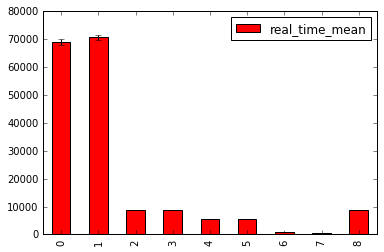

In [29]:
df_ad.plot(y='real_time_mean', yerr='real_time_stddev', kind='bar', color='red')
# df_ad.plot(y='cpu_time_mean', yerr='cpu_time_stddev', kind='bar')

# Motor Estimation
## Performance

In [10]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
print(motor)

Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]


In [25]:
def benchmark_motor_estimation(n_points, num_linear_solver_threads, num_threads, 
                               parameterization='BIVECTOR_GENERATOR'):
    sigma = 0.09
    points_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() 
                for i in range(n_points)]
    points_b = [point.spin(motor) for point in points_a]
    points_b_noisy = [vsr.Vec(*(np.array(point)[:3] 
                                + sigma * np.random.randn(3))).null() 
                      for point in points_b]
    initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    mes = MotorEstimationSolver(initial_motor)
    for a, b in zip(points_a, points_b_noisy):
        mes.add_point_correspondences_residual_block(a,b)
    mes.set_parameterization(parameterization)
    mes.linear_solver_type = 'DENSE_QR'
    mes.num_linear_solver_threads = num_linear_solver_threads
    mes.num_threads = num_threads
    (estimated_motor, summary, motors) = mes.solve()
    results = {}
    results['initial_cost'] = summary['initial_cost']
    results['final_cost'] = summary['final_cost']
    results['num_iterations'] = len(summary['iterations'])
    results['num_residual_blocks'] = summary['num_residual_blocks']
    results['num_linear_solver_threads_given'] = summary['num_linear_solver_threads_given']
    results['num_threads_given'] = summary['num_threads_given']
    results['num_linear_solver_threads_used'] = summary['num_linear_solver_threads_used']
    results['num_threads_used'] = summary['num_threads_used']
    results['num_parameters'] = summary['num_parameters']
    results['num_effective_parameters'] = summary['num_effective_parameters']
    results['num_residuals'] = summary['num_residuals']
    results['jacobian_size'] = (results['num_residuals'], results['num_effective_parameters'])
    results['preprocessor_time'] = summary['preprocessor_time_in_seconds']
    results['residual_evaluation_time'] = summary['residual_evaluation_time_in_seconds']
    results['jacobian_evaluation_time'] = summary['jacobian_evaluation_time_in_seconds']
    results['linear_solver_time'] = summary['linear_solver_time_in_seconds']
    results['minimizer_time'] = summary['minimizer_time_in_seconds']
    results['postprocessor_time'] = summary['postprocessor_time_in_seconds']

    results['total_time'] = summary['total_time_in_seconds']
    return results

In [59]:
results = []
results.append(benchmark_motor_estimation(10, 1,1))
results.append(benchmark_motor_estimation(100, 1,1))
results.append(benchmark_motor_estimation(1000, 1,1))
results.append(benchmark_motor_estimation(10000, 1,1))
results.append(benchmark_motor_estimation(100000, 1,1))
results.append(benchmark_motor_estimation(100000, 1024,1024))
results.append(benchmark_motor_estimation(100000, 1024,1024, 'POLAR_DECOMPOSITION'))

df = pd.DataFrame(results)
df.transpose()

,0,1,2,3,4,5,6
final_cost,0.0908886,1.18397,11.8567,122.086,1216.91,1214.35,1213.94
initial_cost,24.1995,229.966,2192.31,21478.3,215743,214948,214762
jacobian_evaluation_time,0.000289684,0.00186856,0.0181398,0.169156,1.70207,0.277806,0.346677
jacobian_size,"(30, 6)","(300, 6)","(3000, 6)","(30000, 6)","(300000, 6)","(300000, 6)","(300000, 8)"
linear_solver_time,5.0649e-05,9.8791e-05,0.000801417,0.0085729,0.104154,0.110753,0.219843
minimizer_time,0.000514854,0.0021571,0.0197209,0.183851,1.87785,0.432591,0.631904
num_effective_parameters,6,6,6,6,6,6,8
num_iterations,5,4,4,4,4,4,5
num_linear_solver_threads_given,1,1,1,1,1,1024,1024
num_linear_solver_threads_used,1,1,1,1,1,1024,1024


In [68]:
results = [benchmark_motor_estimation(100000, 1024,1024) for i in range(10)]
df = pd.DataFrame(results)
df.transpose()

,0,1,2,3,4,5,6,7,8,9
final_cost,1213.27,1220.7,1214.53,1216.08,1211.61,1219.48,1213.45,1213.71,1219.55,1211.38
initial_cost,215670,215035,215393,213911,214638,214612,214659,214799,214926,215254
jacobian_evaluation_time,0.279146,0.277593,0.281622,0.273442,0.275768,0.277411,0.282477,0.27497,0.278475,0.281021
jacobian_size,"(300000, 6)","(300000, 6)","(300000, 6)","(300000, 6)","(300000, 6)","(300000, 6)","(300000, 6)","(300000, 6)","(300000, 6)","(300000, 6)"
linear_solver_time,0.110987,0.107631,0.107332,0.109721,0.10645,0.107519,0.107289,0.107052,0.10726,0.10749
minimizer_time,0.434406,0.429617,0.433499,0.42923,0.431851,0.429791,0.435381,0.428549,0.430913,0.434675
num_effective_parameters,6,6,6,6,6,6,6,6,6,6
num_iterations,4,4,4,4,4,4,4,4,4,4
num_linear_solver_threads_given,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024
num_linear_solver_threads_used,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024


In [70]:
(df['total_time'].mean(), df['total_time'].std())

(0.45942879209469539, 0.0023034426002333003)

In [72]:
results = [benchmark_motor_estimation(100000, 1024,1024, 'POLAR_DECOMPOSITION') for i in range(10)]
df = pd.DataFrame(results)
df.transpose()
(df['total_time'].mean(), df['total_time'].std())

(0.66033865059434904, 0.01459742644416717)

In [73]:
df

,final_cost,initial_cost,jacobian_evaluation_time,jacobian_size,linear_solver_time,minimizer_time,num_effective_parameters,num_iterations,num_linear_solver_threads_given,num_linear_solver_threads_used,num_parameters,num_residual_blocks,num_residuals,num_threads_given,num_threads_used,postprocessor_time,preprocessor_time,residual_evaluation_time,total_time
0,1212.388026,214686.678595,0.344102,"(300000, 8)",0.217258,0.626744,8,5,1024,1024,8,100000,300000,1024,1024,0.004486,0.023254,0.026127,0.654485
1,1212.247764,214718.217145,0.342964,"(300000, 8)",0.217125,0.627171,8,5,1024,1024,8,100000,300000,1024,1024,0.004542,0.023078,0.028050,0.654791
2,1216.511057,214876.465404,0.345010,"(300000, 8)",0.217386,0.626004,8,5,1024,1024,8,100000,300000,1024,1024,0.004662,0.023796,0.024701,0.654462
3,1214.826707,215182.537102,0.344307,"(300000, 8)",0.216663,0.626665,8,5,1024,1024,8,100000,300000,1024,1024,0.004518,0.023868,0.026589,0.655051
4,1216.120300,215319.762931,0.342882,"(300000, 8)",0.217303,0.624427,8,5,1024,1024,8,100000,300000,1024,1024,0.004636,0.023531,0.025125,0.652594
5,1216.962387,215315.746295,0.343021,"(300000, 8)",0.216587,0.628748,8,5,1024,1024,8,100000,300000,1024,1024,0.004536,0.023440,0.030235,0.656724
6,1215.363467,214623.836677,0.347204,"(300000, 8)",0.217291,0.632592,8,5,1024,1024,8,100000,300000,1024,1024,0.004675,0.023430,0.028699,0.660698
7,1217.241708,215459.319171,0.374208,"(300000, 8)",0.228890,0.672964,8,5,1024,1024,8,100000,300000,1024,1024,0.004914,0.023554,0.028018,0.701432
8,1220.354666,215123.675232,0.345048,"(300000, 8)",0.217569,0.628218,8,5,1024,1024,8,100000,300000,1024,1024,0.004707,0.023772,0.026547,0.656698
9,1215.977945,215060.578854,0.344257,"(300000, 8)",0.216930,0.628732,8,5,1024,1024,8,100000,300000,1024,1024,0.004513,0.023204,0.028499,0.656450


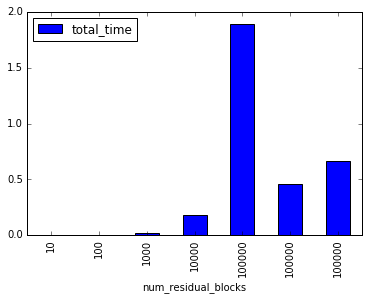

In [58]:
df.plot(x='num_residual_blocks', y='total_time', kind='bar')

In [16]:
n_points=10
sigma = 0.09
points_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() 
            for i in range(n_points)]
points_b = [point.spin(motor) for point in points_a]
points_b_noisy = [vsr.Vec(*(np.array(point)[:3] 
                            + sigma * np.random.randn(3))).null() 
                  for point in points_b]
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(points_a, points_b_noisy):
    mes.add_point_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
mes.num_linear_solver_threads = 1
mes.num_threads = 1
(estimated_motor, summary, motors) = mes.solve()
print(summary['full_report'])


Solver Summary (v 1.11.0-eigen-(3.2.92)-lapack-suitesparse-(4.4.6)-openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   30                       30

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1

Cost:
Initial                          2.049113e+01
Final              

In [18]:
pd.DataFrame(summary).transpose()

,0,1,2,3
brief_report,"Ceres Solver Report: Iterations: 3, Initial co...","Ceres Solver Report: Iterations: 3, Initial co...","Ceres Solver Report: Iterations: 3, Initial co...","Ceres Solver Report: Iterations: 3, Initial co..."
final_cost,0.0706572,0.0706572,0.0706572,0.0706572
full_report,\nSolver Summary (v 1.11.0-eigen-(3.2.92)-lapa...,\nSolver Summary (v 1.11.0-eigen-(3.2.92)-lapa...,\nSolver Summary (v 1.11.0-eigen-(3.2.92)-lapa...,\nSolver Summary (v 1.11.0-eigen-(3.2.92)-lapa...
initial_cost,20.4911,20.4911,20.4911,20.4911
iterations,"{u'cost_change': 0.0, u'eta': 0.1, u'trust_reg...","{u'cost_change': 19.0391770568, u'eta': 0.0, u...","{u'cost_change': 1.37232847266, u'eta': 0.0, u...","{u'cost_change': 0.00896747499682, u'eta': 0.0..."
jacobian_evaluation_time_in_seconds,0.000302564,0.000302564,0.000302564,0.000302564
linear_solver_time_in_seconds,4.7649e-05,4.7649e-05,4.7649e-05,4.7649e-05
linear_solver_type_used,DENSE_QR,DENSE_QR,DENSE_QR,DENSE_QR
message,Function tolerance reached. |cost_change|/cost...,Function tolerance reached. |cost_change|/cost...,Function tolerance reached. |cost_change|/cost...,Function tolerance reached. |cost_change|/cost...
minimizer_time_in_seconds,0.000528568,0.000528568,0.000528568,0.000528568


In [16]:
time_10_1_1 = [benchmark_motor_estimation(10, 1,1) for i in range(1000)]
print(np.mean(time_10_1_1))
print(np.std(time_10_1_1))

0.00050008401298
9.47762783549e-05


In [31]:
time_100_4_4 = [benchmark_motor_estimation(10000, 128,32) for i in range(100)]
print(np.mean(time_100_4_4))
print(np.std(time_100_4_4))

0.0476819423995
0.00166339272053


In [18]:
# n_points = [10, 100, 1000, 10000, 100000]
n_points = [10]
n_linear_solver_threads = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
n_threads = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

In [19]:
res = {}
for i in n_points:
    for j in n_linear_solver_threads:
        for k in n_threads:
            total_time_in_seconds = benchmark_motor_estimation(i, j, k)
            res['{}_{}_{}'.format(i,j,k)] = total_time_in_seconds

In [20]:
print(res)

{'10_32_8': 0.025593224010663107, '10_2_1024': 0.041082893003476784, '10_1024_16': 0.0011323950020596385, '10_32_16': 0.0008658270089654252, '10_16_2048': 0.08148157800314948, '10_512_4': 0.00047682800504844636, '10_8_256': 0.009256713005015627, '10_128_2048': 0.0783414440084016, '10_512_2': 0.0061107290093787014, '10_64_2': 0.004629538001609035, '10_64_1': 0.0005250029935268685, '10_16_128': 0.007412380000459962, '10_64_4': 0.021858391002751887, '10_1024_8': 0.0005058050010120496, '10_64_8': 0.007026721999864094, '10_1024_4': 0.02503840198914986, '10_1024_2': 0.007055437003145926, '10_1024_1': 0.0005112130020279437, '10_256_32': 0.0012756069918395951, '10_64_256': 0.009087282000109553, '10_1_128': 0.013435982997179963, '10_4_16': 0.0009957559959730133, '10_2048_1': 0.0005131849902682006, '10_2_2048': 0.08146405201114248, '10_16_1024': 0.03737701699719764, '10_512_1024': 0.03114715698757209, '10_8_1024': 0.03170252501149662, '10_16_32': 0.0015387700113933533, '10_1024_64': 0.0025022150

In [21]:
summary['jacobian_evaluation_solver_time_in_seconds']

NameError: name 'summary' is not defined